In [1]:
import time
import json
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
from IPython import display
from matplotlib import pyplot as plt
from matplotlib.text import Text
%matplotlib inline

# Settings

In [2]:
meta_dir = "D:\\math\\res12.04.2019T06_56_23"
data_dir = "D:\\math\\res12.04.2019T06_56_23"
fourier_dir = "D:\\rk smooth fourier"
pic_dir = ""

def set_lineplot():
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['grid.color'] = 'gray'  
    plt.rcParams['axes.grid'] = True
    plt.rcParams['lines.linewidth'] = 5
    plt.rcParams['font.size'] = 24

def set_heatmap():
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.figsize'] = [20, 10]

# Drawing

In [3]:
class Draw:
    def heatmap(df,start,end,xticks,xticklabels,yticks,yticklabels,cmap,transpose = False,save_path = ''):       
        plt.clf()
        plt.cla()
        df = pd.DataFrame(df.iloc[start:end])
        if transpose:
            df = df.transpose().iloc[::-1]
        pic = sns.heatmap(df,xticklabels=False,yticklabels=False,cmap=cmap,cbar_kws = dict(use_gridspec=False,location="top"))
        pic.set_xticks(xticks)
        pic.set_xticklabels(xticklabels)
        pic.set_yticks(yticks)
        pic.set_yticklabels(np.flip(yticklabels))
        if save_path == '':
            plt.show()
        else:
            plt.savefig(save_path)    
        del df

# Data wrapper

In [144]:
class Result:
    def __init__(self,_id):
        onlyfiles = [os.path.join(meta_dir, f) for f in os.listdir(meta_dir) if os.path.isfile(os.path.join(meta_dir, f))]
        path_to_meta = next(filter(lambda x: _id in x and '_meta' in x,onlyfiles))
        with open(path_to_meta,'r') as f:
            lines = f.readlines()
            self.meta = json.loads(lines[0])
            self.end_u = np.fromstring(lines[1][1:-2],sep=',',dtype=np.float)
            self.end_v = np.fromstring(lines[2][1:-2],sep=',',dtype=np.float)
            self.start_u = np.array(self.meta['InitStateU'],dtype = np.float)
            del self.meta['InitStateU']
            self.start_v = np.array(self.meta['InitStateV'],dtype = np.float)
            del self.meta['InitStateV']
            self.meta['TimeLineQuant']*=self.meta['TimeQuant']
            self.space_net = np.fromiter([i * self.meta['SpaceQuant'] for i in range(0,int(self.meta['SpaceRange']/self.meta['SpaceQuant']))],dtype=np.float)
    def draw_end_u(self):
        set_lineplot()
        sns.lineplot(self.space_net, self.end_u)
    def draw_start_u(self):
        set_lineplot()
        sns.lineplot(self.space_net, self.start_u)
    def draw_end_v(self):
        set_lineplot()
        sns.lineplot(self.space_net, self.end_v)
    def draw_start_v(self):
        set_lineplot()
        sns.lineplot(self.space_net, self.start_v)
    def draw_heatmap(self,start, end,x_freq, cmap = 'cividis', display = True):
        set_heatmap()
        plt.clf()
        onlyfiles = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
        path_to_data = next(filter(lambda x: str(self.meta['Id']) in x and '_data' in x,onlyfiles))
        data = pd.read_csv(path_to_data,sep=';',dtype=np.float)
        start_scaled = max(0,int(start/self.meta['TimeLineQuant']))
        end_scaled = min(int(end/self.meta['TimeLineQuant']),len(data.index)-1)
        if display:
            savepath = ''
        else:
            savepath = pic_dir+'\\'+str(self.meta['Id'])+'_'+str(start)+'_'+str(end)+'.png'
        x_freq_scaled = int(x_freq/self.meta['TimeLineQuant'])
        xticks = np.linspace(0,(end_scaled-start_scaled) - (end_scaled-start_scaled)%x_freq_scaled,x_freq+1,dtype=np.int)
        xticklabels = np.array([int(x*self.meta['TimeLineQuant']+start) for x in xticks],dtype=np.str)
        xticklabels[-1] = 't'
        yticks = np.linspace(0,self.meta['SpaceRange']/self.meta['SpaceQuant'],5,dtype=np.int)
        ytickslabels = np.linspace(0,self.meta['SpaceRange'],5,dtype=np.int)
        ytickslabels = np.array(ytickslabels,dtype=np.str)
        ytickslabels[0]=''
        ytickslabels[-1] = 'x'
        Draw.heatmap(data,start_scaled,end_scaled,xticks,xticklabels,yticks,ytickslabels,cmap,True,savepath)
        del data
    def draw_fourier(self,start,end,names):
        if not hasattr(self,'data'):
            onlyfiles = [os.path.join(fourier_dir, f) for f in os.listdir(fourier_dir) if os.path.isfile(os.path.join(fourier_dir, f))]
            path_to_data = next(filter(lambda x: str(self.meta['Id']) in x and '_Fourier' in x,onlyfiles))
            self.data = pd.read_csv(path_to_data,sep=' ',dtype=float)
        set_lineplot()
        start_scaled = int(start/self.meta['TimeLineQuant'])
        end_scaled = int(end/self.meta['TimeLineQuant'])    
        start_scaled = max(0,int(start/self.meta['TimeLineQuant']))
        end_scaled = min(int(end/self.meta['TimeLineQuant']),len(self.data.index)-1)
        data = self.data[names].iloc[start_scaled:end_scaled]
        pic = data.plot.line(color = sns.color_palette('tab20',len(data)),legend=False)
        pic.legend()
        pic.set_xlim(start_scaled,end_scaled)
        pic.set_xticklabels(np.array([sas*self.meta['TimeLineQuant'] for sas in pic.get_xticks()]))
        xlbls = pic.get_xticklabels()
        xlbls[-1]='t'
        pic.set_xticklabels(xlbls)
        ylabels = np.array(pic.get_yticks(),dtype=np.str)
        ylabels[-2] = 'm'
        pic.set_yticklabels(ylabels)
        plt.show()
    def draw_fourier_range(self,start,end,namestart,nameend):    
        if not hasattr(self,'data'):
            onlyfiles = [os.path.join(fourier_dir, f) for f in os.listdir(fourier_dir) if os.path.isfile(os.path.join(fourier_dir, f))]
            path_to_data = next(filter(lambda x: str(self.meta['Id']) in x and '_Fourier' in x,onlyfiles))
            self.data = pd.read_csv(path_to_data,sep=' ',dtype=float)
        self.draw_fourier(start,end,list(self.data.loc[:,namestart:nameend]))
    
    
def get_kok(num):
    i = 0
    while num > 0:
        num = num // 10
        i+=1
    return i

In [145]:
get_kok(100)

3

In [146]:
a = Result(os.path.join(meta_dir,'-1478802681'))

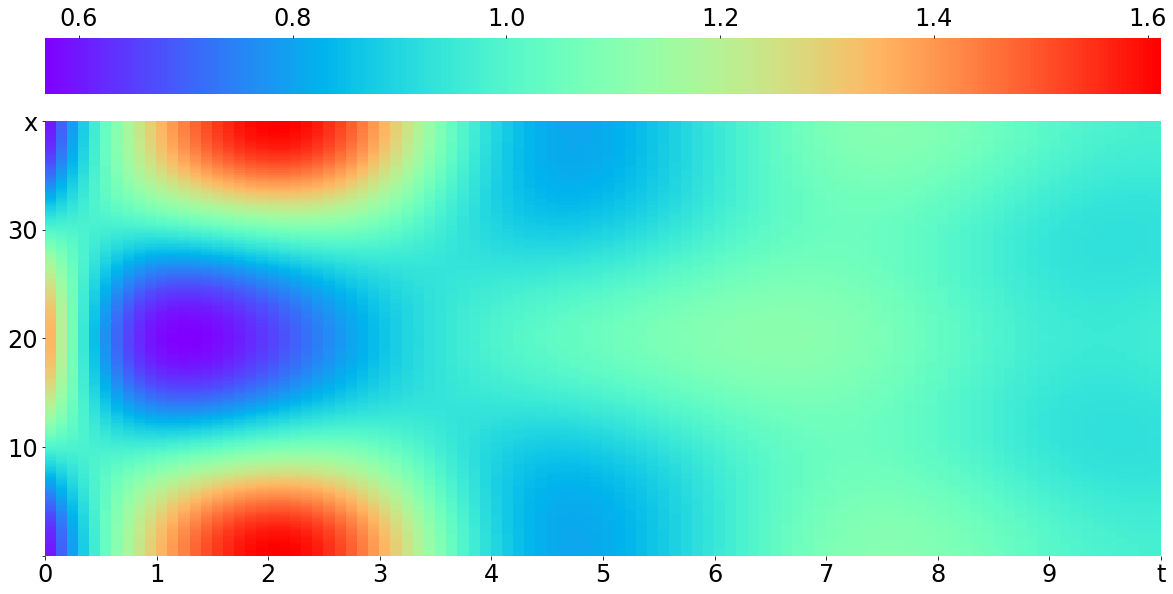

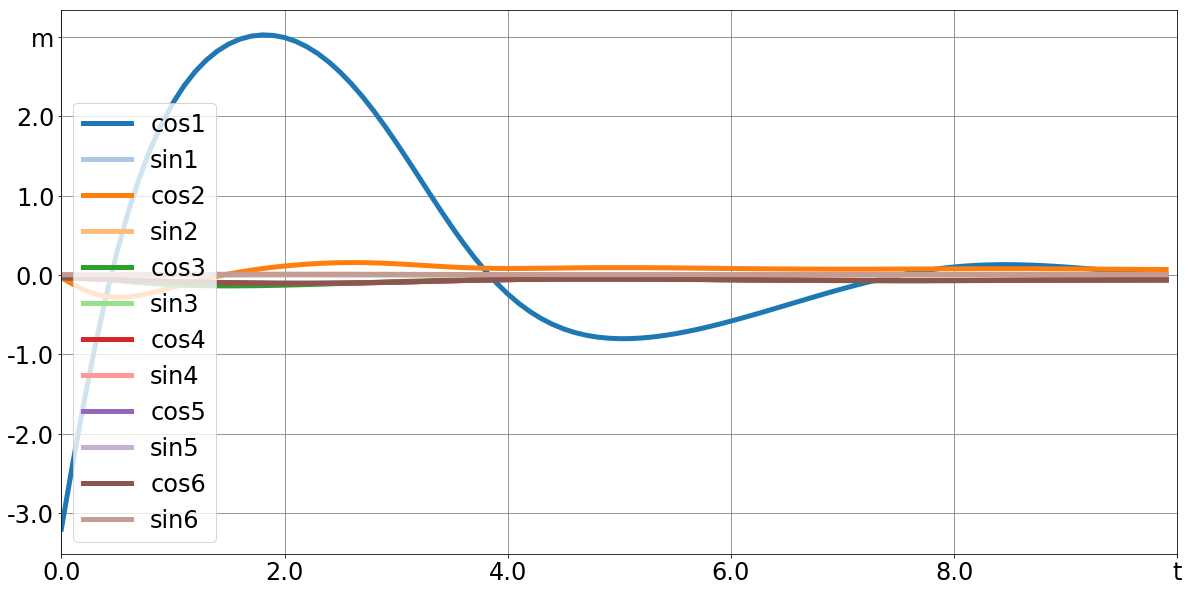

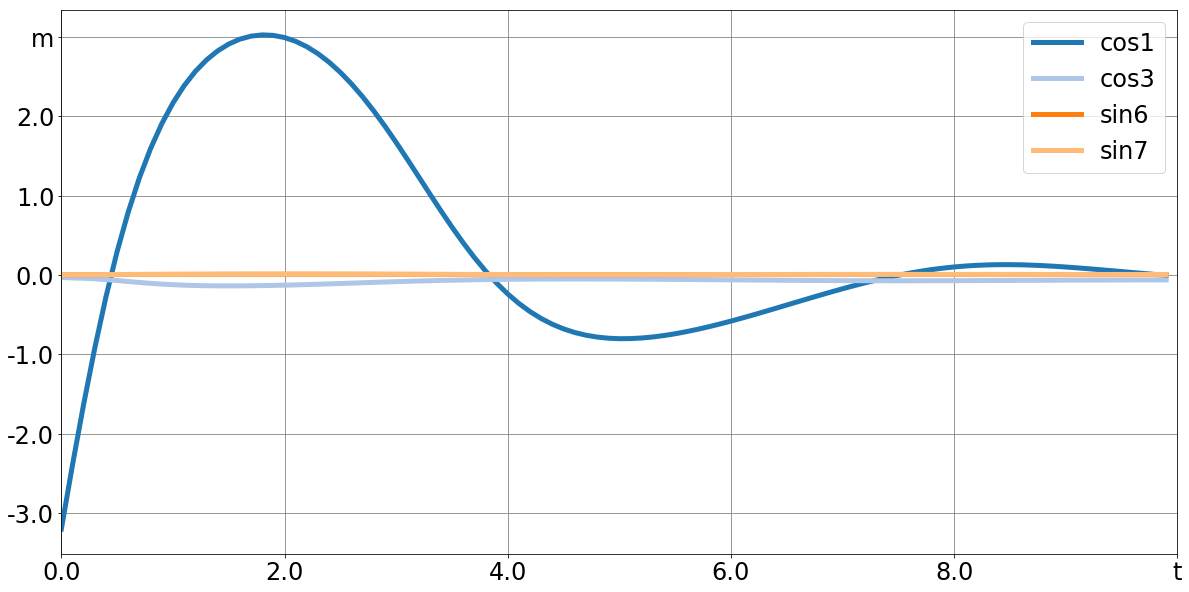

In [147]:
a.draw_heatmap(0,10,10,cmap="rainbow")
a.draw_fourier_range(0,10,'cos1','sin6')
a.draw_fourier(0,10,['cos1','cos3','sin6','sin7'])

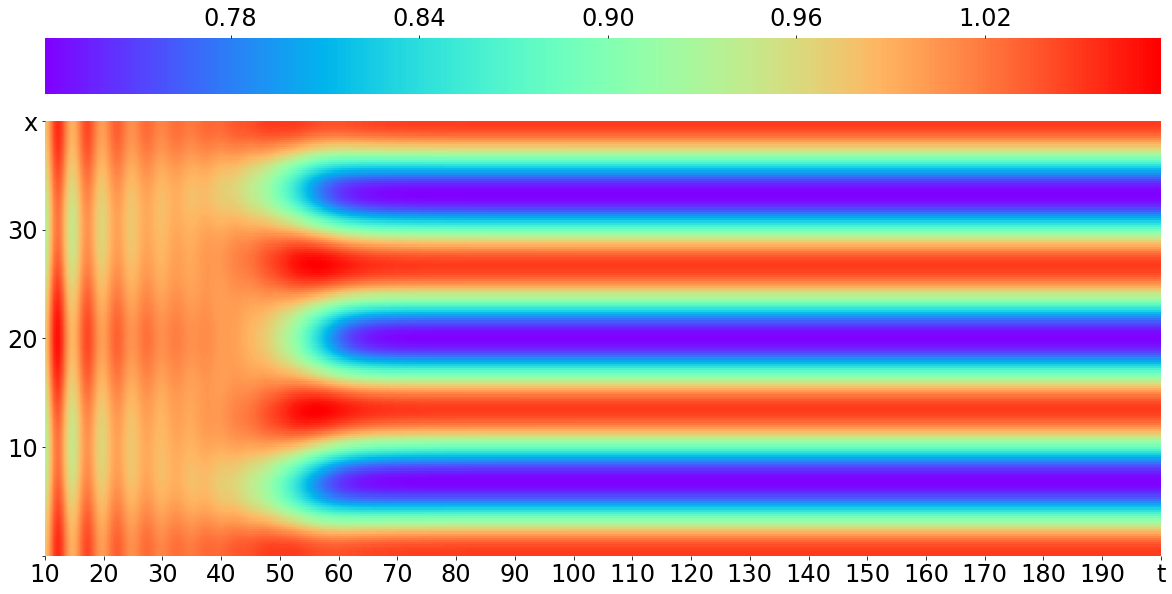

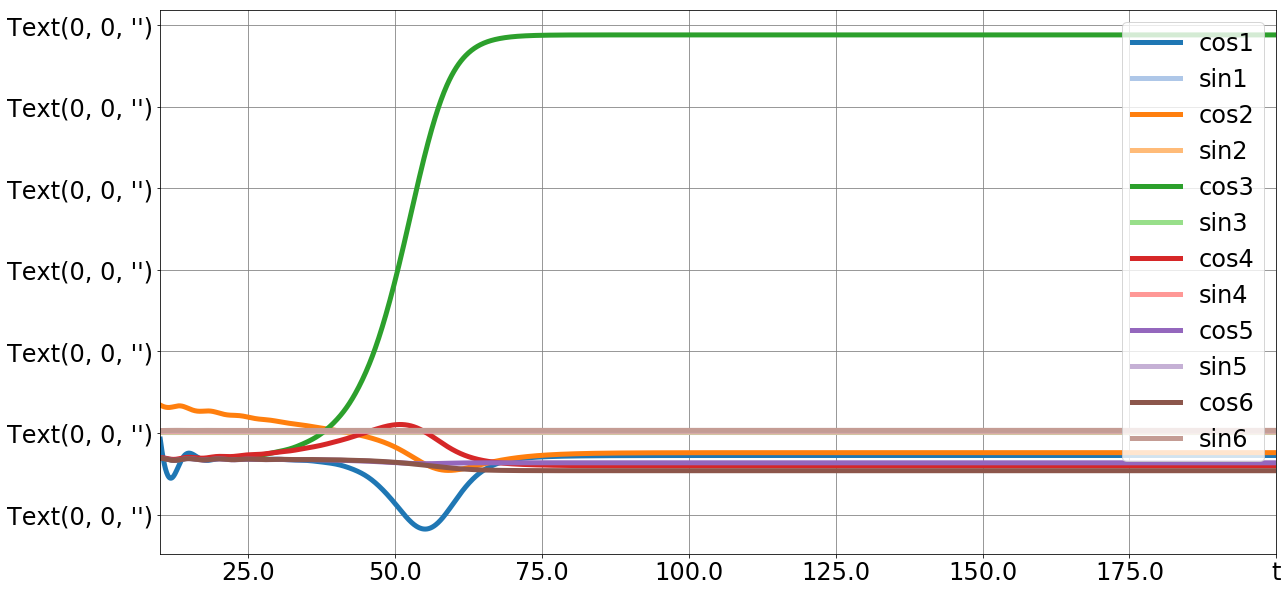

In [88]:
a.draw_heatmap(10,200,19,cmap="rainbow")
a.draw_fourier_range(10,200,'cos1','sin6')

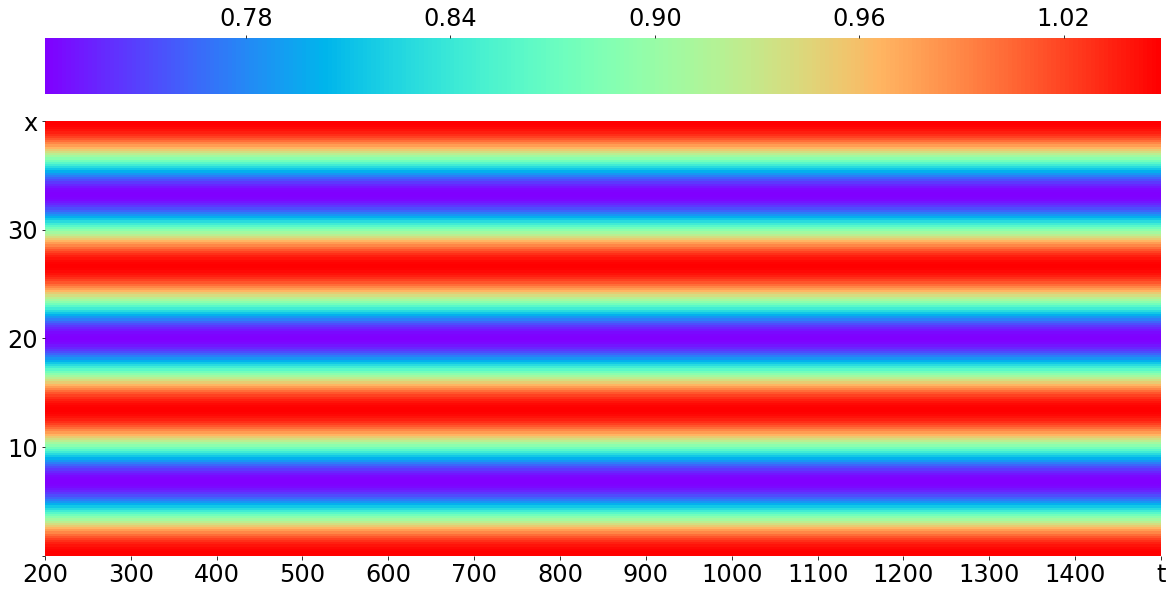

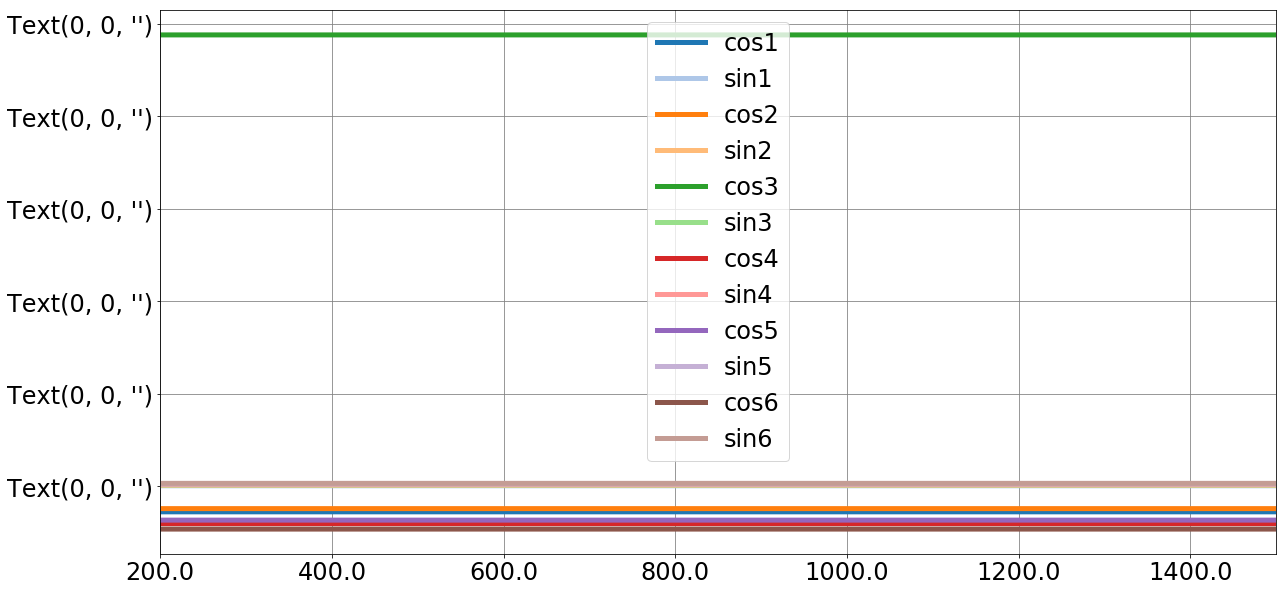

In [89]:
a.draw_heatmap(200,1500,13,cmap="rainbow")
a.draw_fourier_range(200,1500,'cos1','sin6')

In [57]:
1//0.2

4.0

In [58]:
1/0.2

5.0

ZeroDivisionError: integer division or modulo by zero

Accent


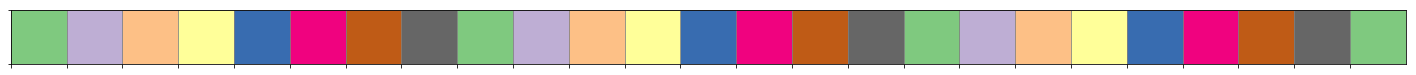

Accent_r


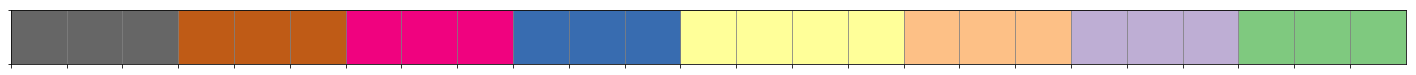

Blues


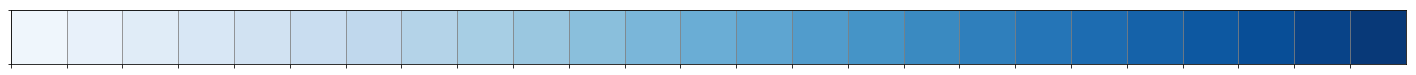

Blues_r


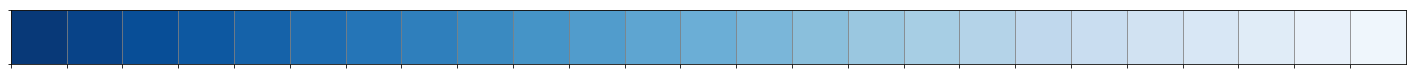

BrBG


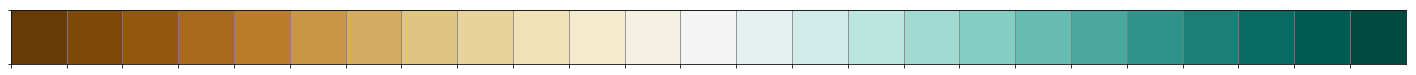

BrBG_r


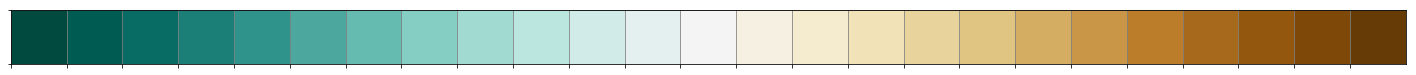

BuGn


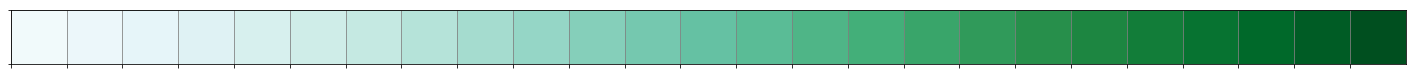

BuGn_r


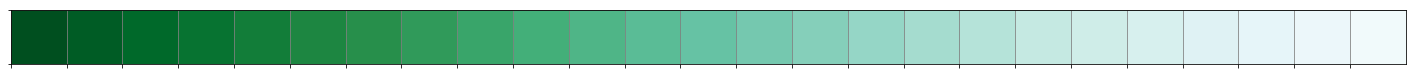

BuPu


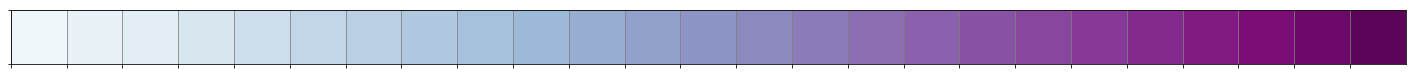

BuPu_r


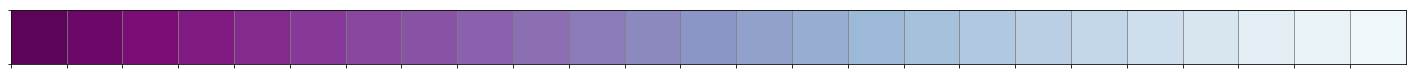

CMRmap


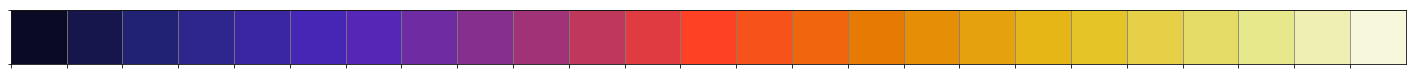

CMRmap_r


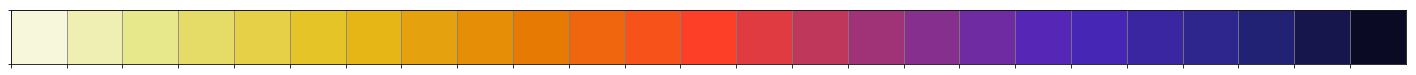

Dark2


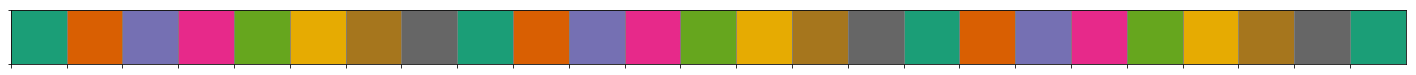

Dark2_r


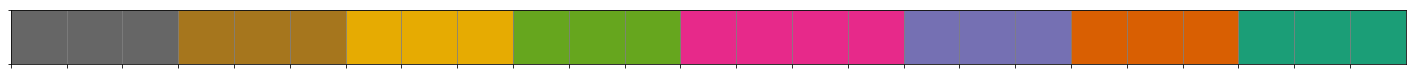

GnBu


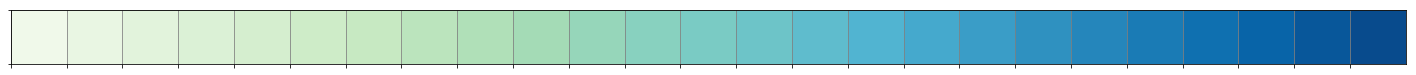

GnBu_r


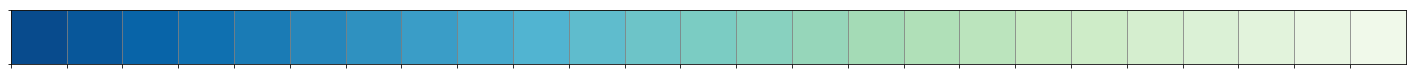

Greens


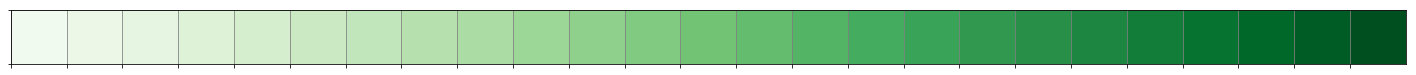

Greens_r


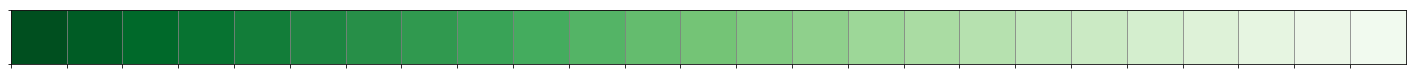

Greys


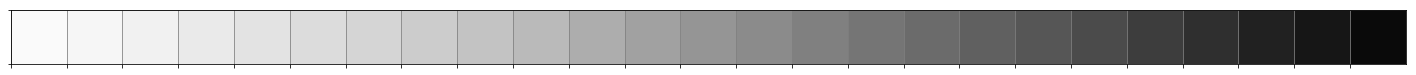

Greys_r


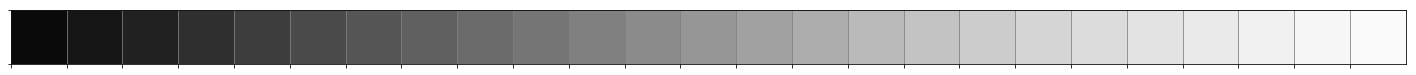

OrRd


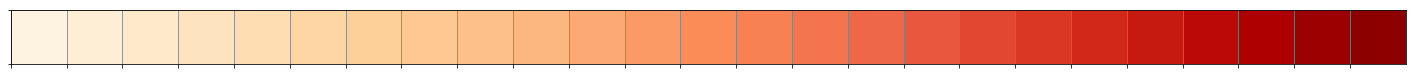

OrRd_r


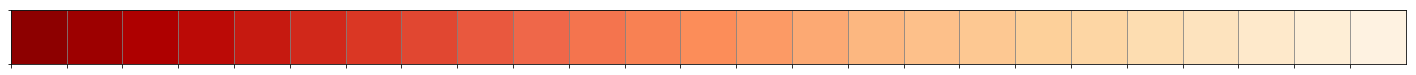

Oranges


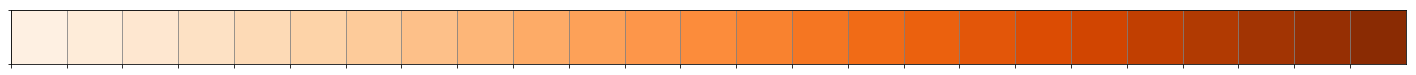

Oranges_r


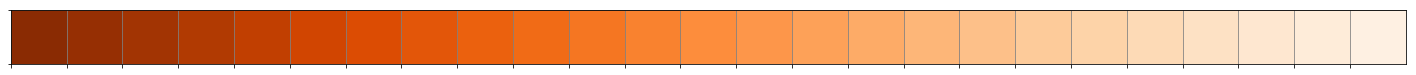

PRGn


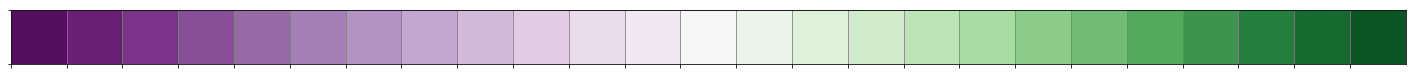

PRGn_r


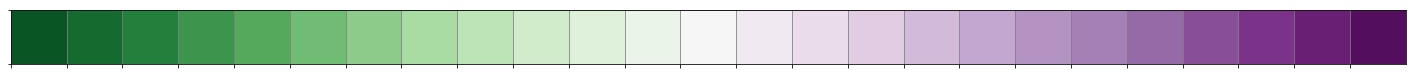

Paired


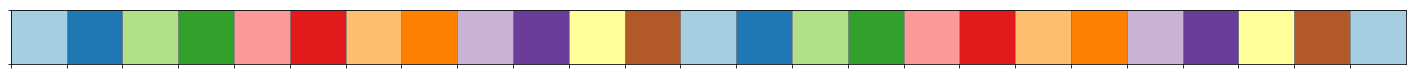

Paired_r


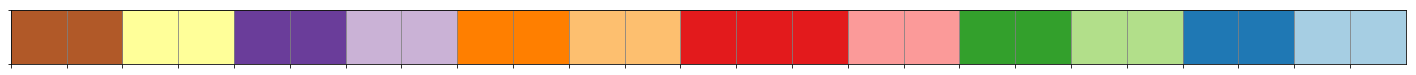

Pastel1


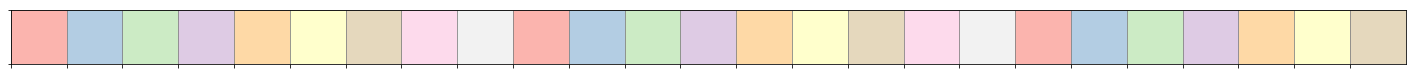

Pastel1_r


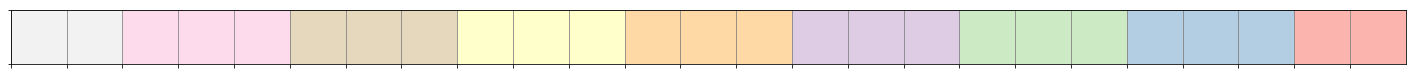

Pastel2


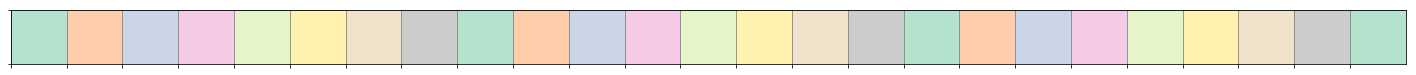

Pastel2_r


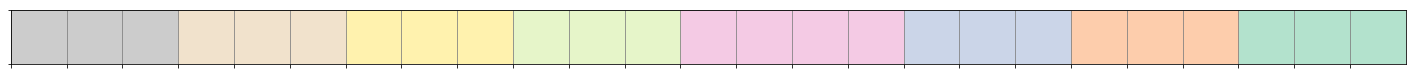

PiYG


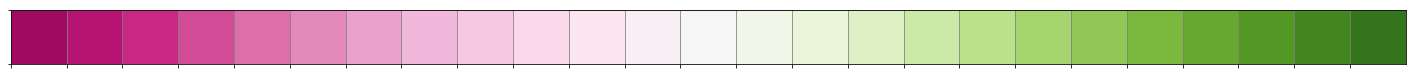

PiYG_r


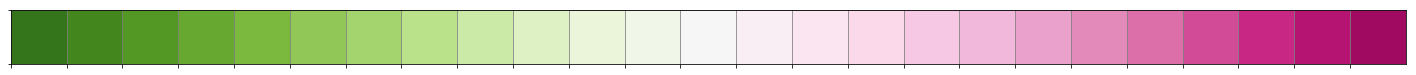

PuBu


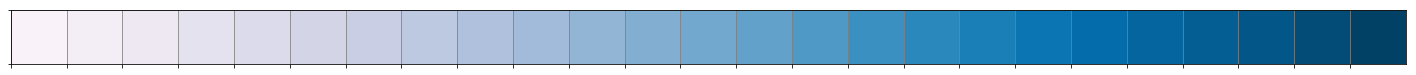

PuBuGn


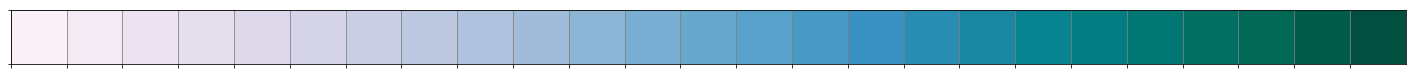

PuBuGn_r


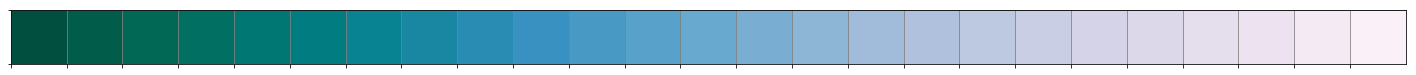

PuBu_r


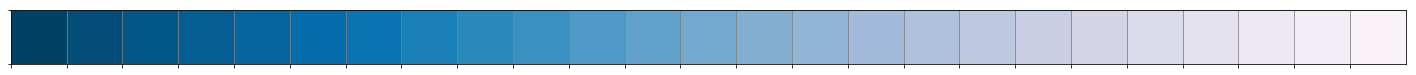

PuOr


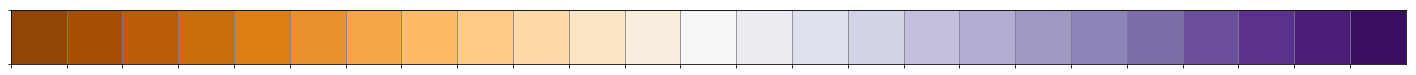

PuOr_r


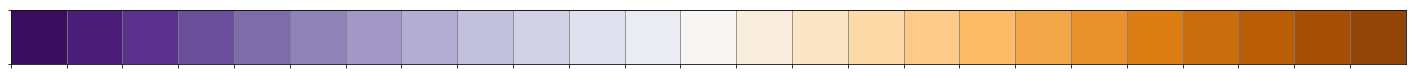

PuRd


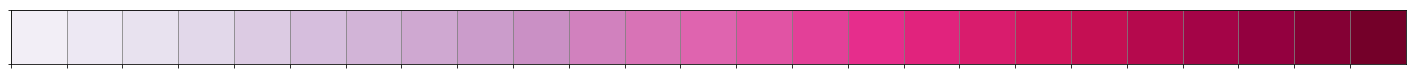

PuRd_r


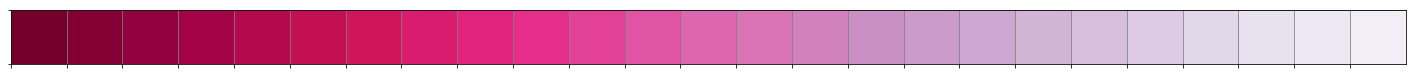

Purples


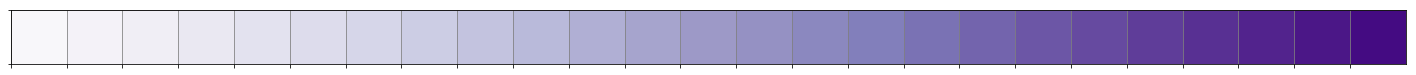

Purples_r


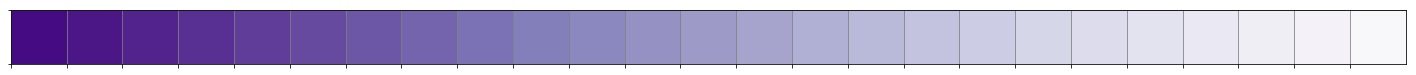

RdBu


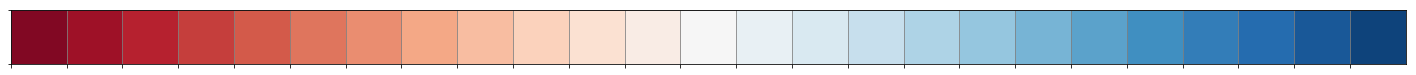

RdBu_r


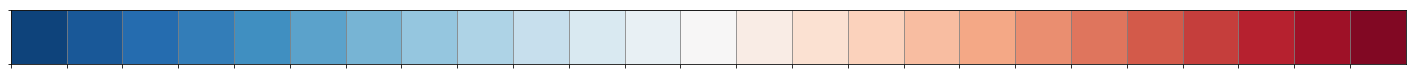

RdGy


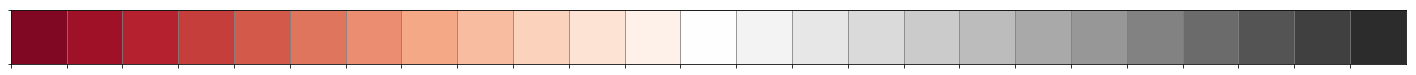

RdGy_r


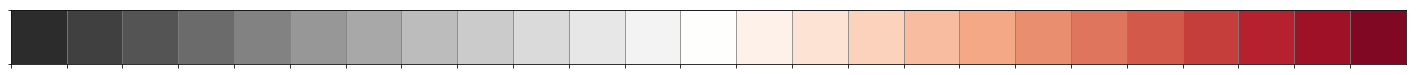

RdPu


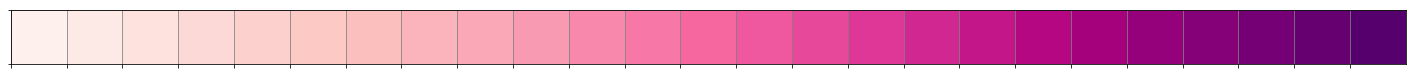

RdPu_r


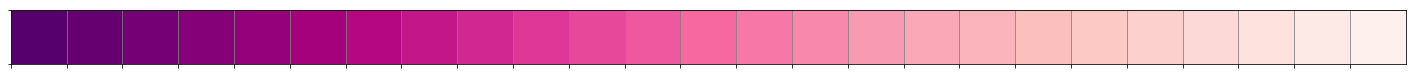

RdYlBu


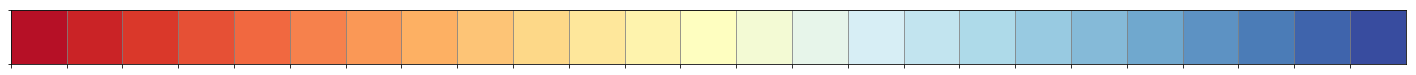

RdYlBu_r


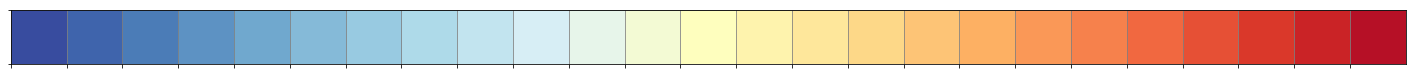

RdYlGn


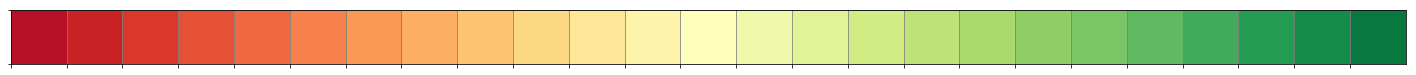

RdYlGn_r


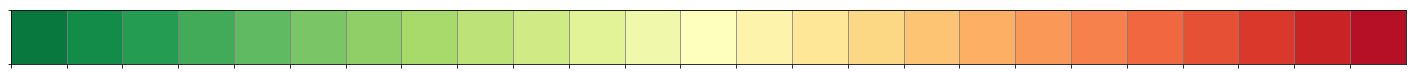

Reds


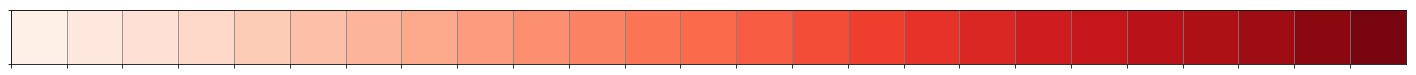

Reds_r


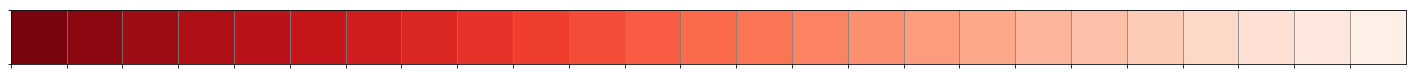

Set1


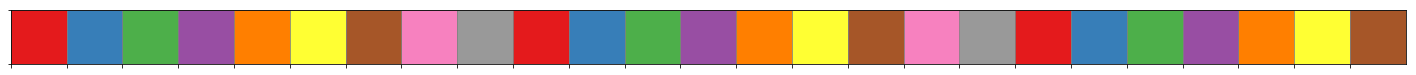

Set1_r


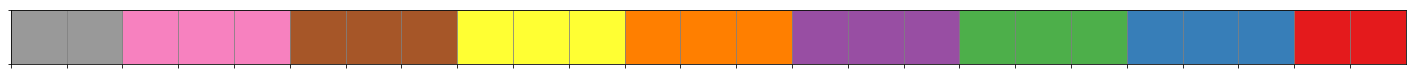

Set2


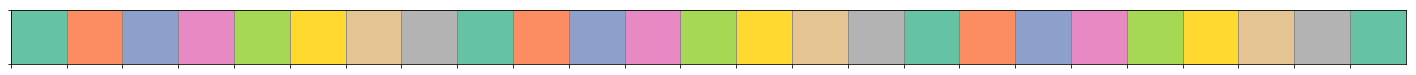

Set2_r


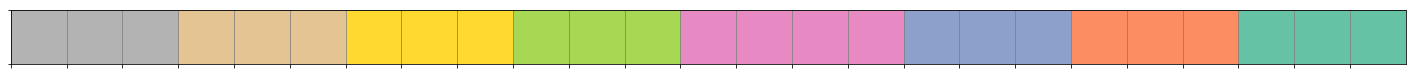

Set3


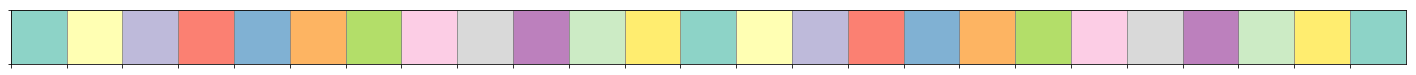

Set3_r


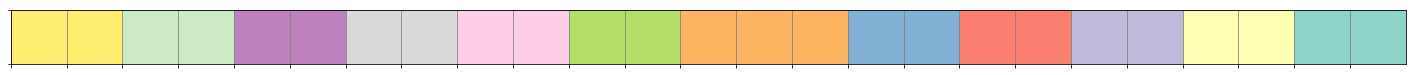

Spectral


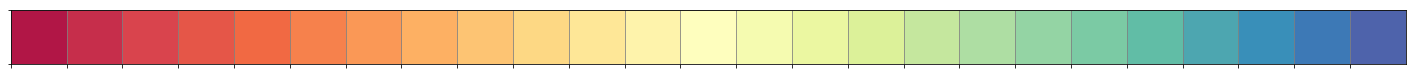

Spectral_r


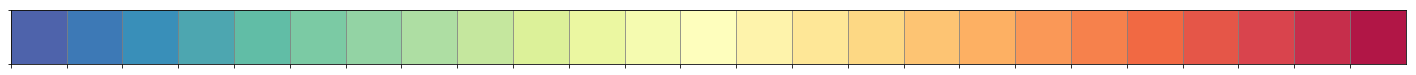

Wistia


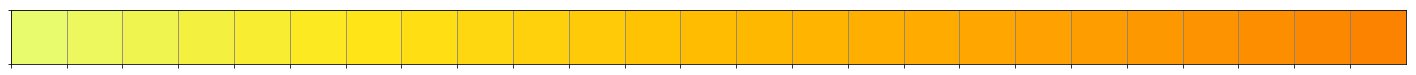

Wistia_r


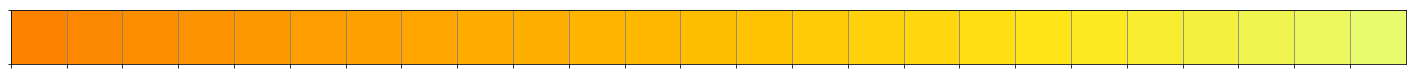

YlGn


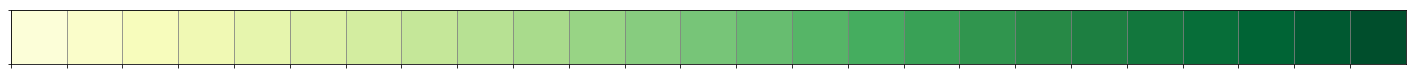

YlGnBu


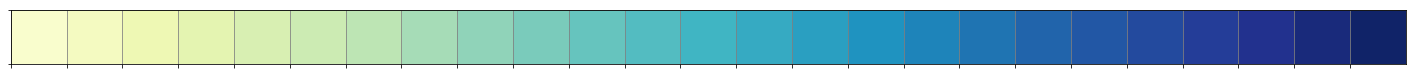

YlGnBu_r


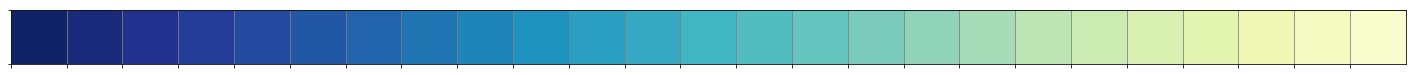

YlGn_r


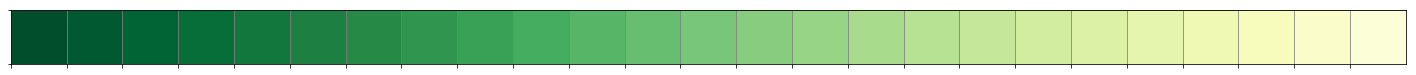

YlOrBr


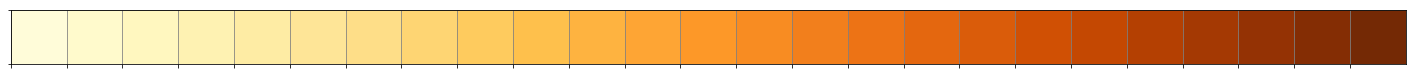

YlOrBr_r


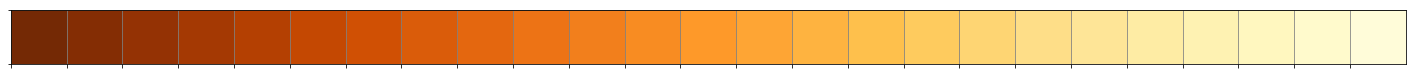

YlOrRd


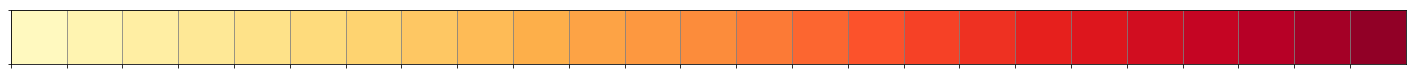

YlOrRd_r


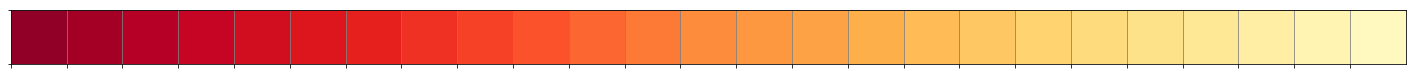

afmhot


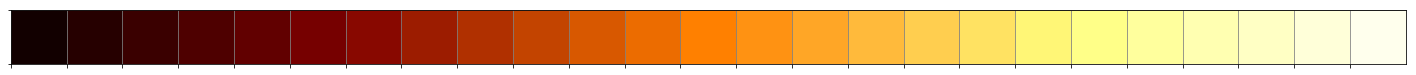

afmhot_r


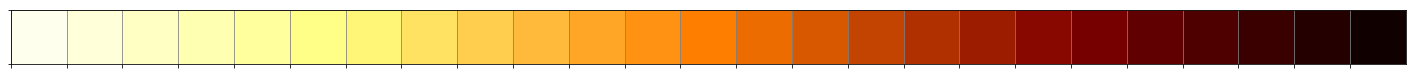

autumn


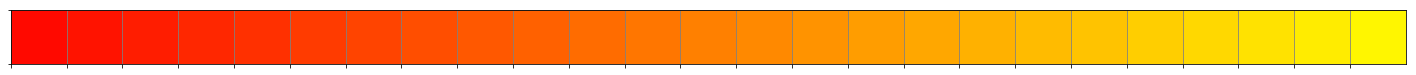

autumn_r


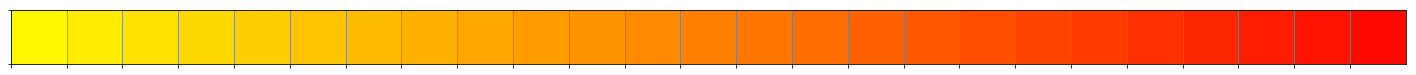

binary


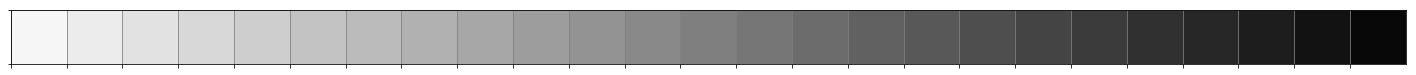

binary_r


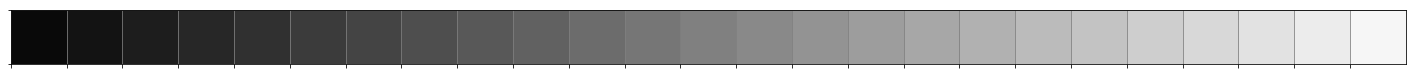

bone


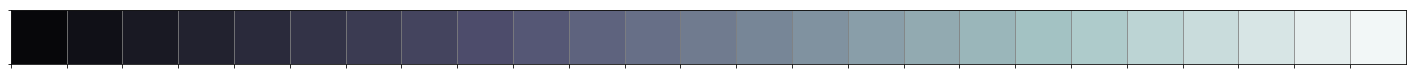

bone_r


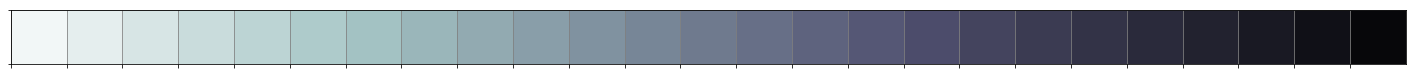

brg


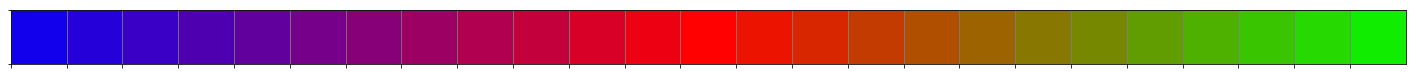

brg_r


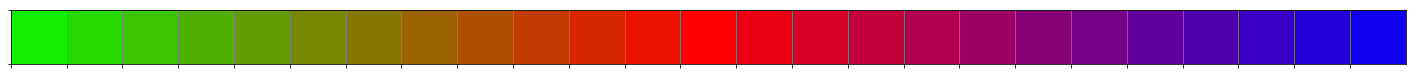

bwr


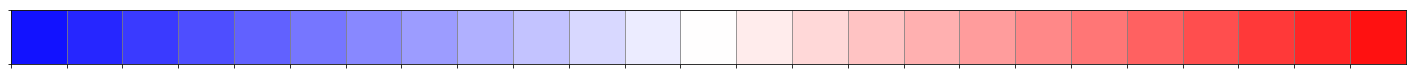

bwr_r


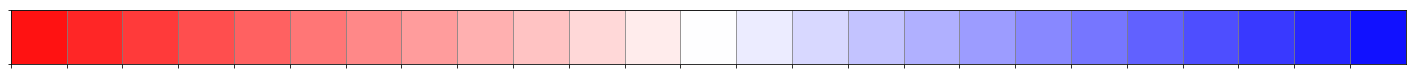

cividis


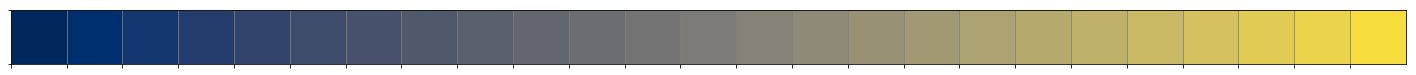

cividis_r


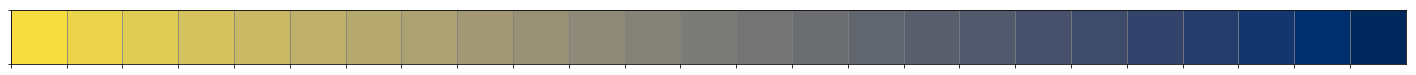

cool


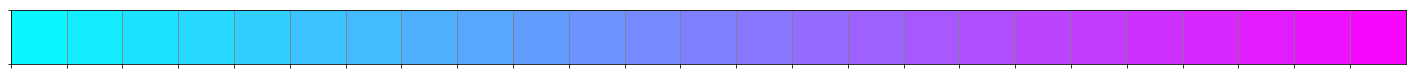

cool_r


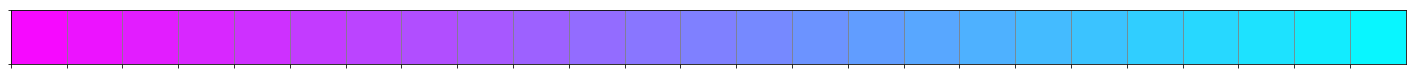

coolwarm


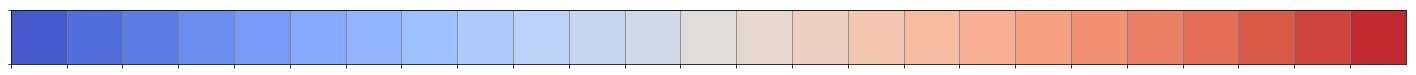

coolwarm_r


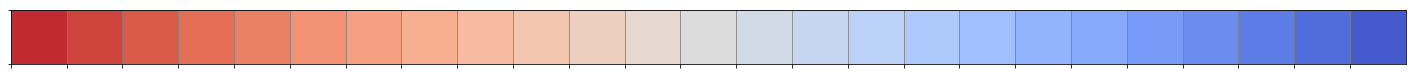

copper


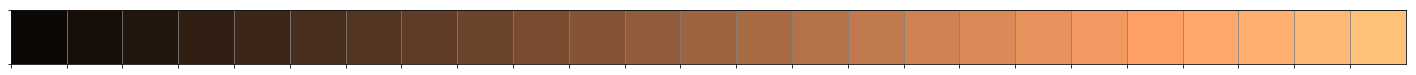

copper_r


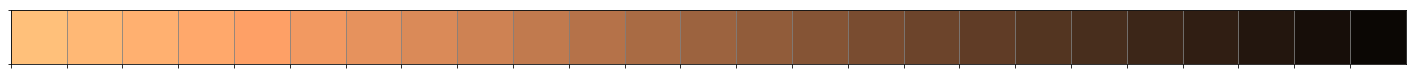

cubehelix


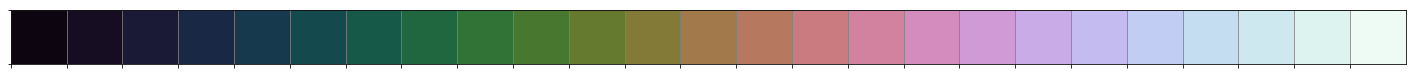

cubehelix_r


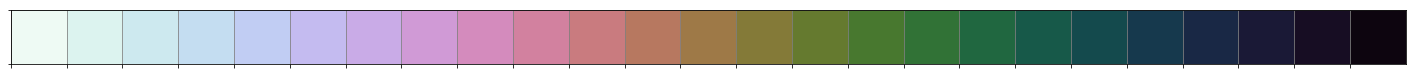

flag


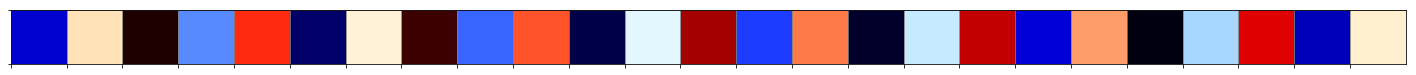

flag_r


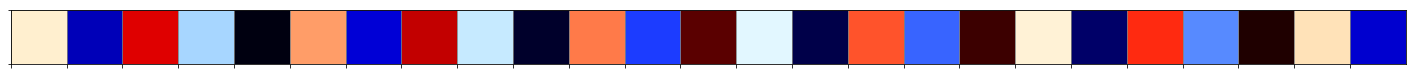

gist_earth


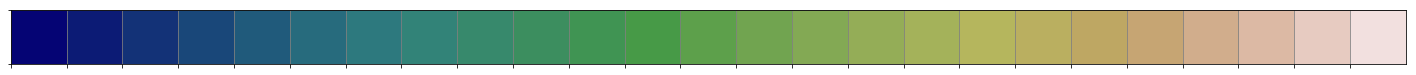

gist_earth_r


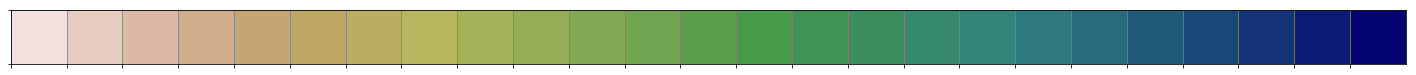

gist_gray


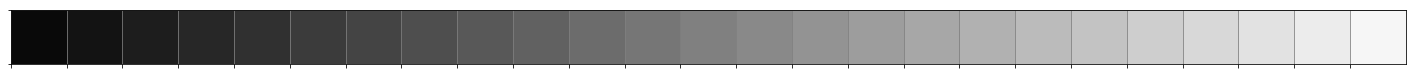

gist_gray_r


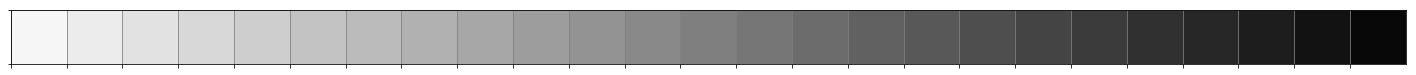

gist_heat


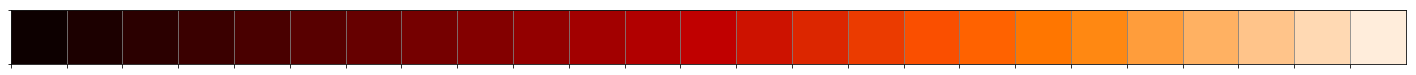

gist_heat_r


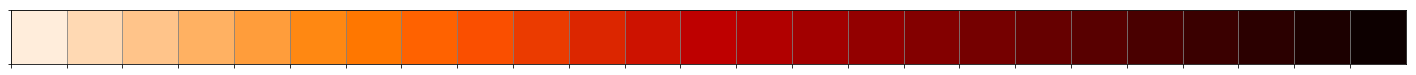

gist_ncar


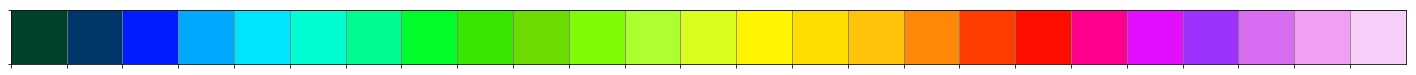

gist_ncar_r


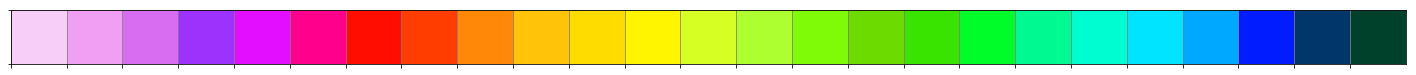

gist_rainbow


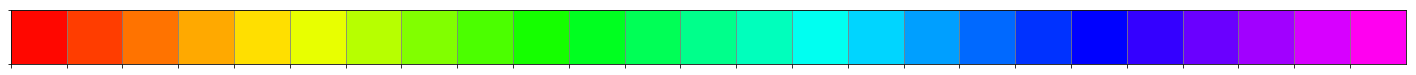

gist_rainbow_r


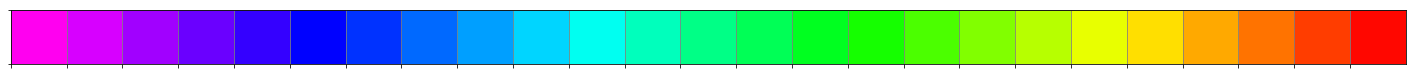

gist_stern


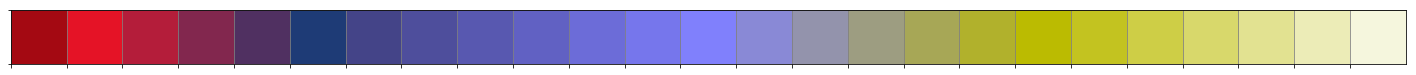

gist_stern_r


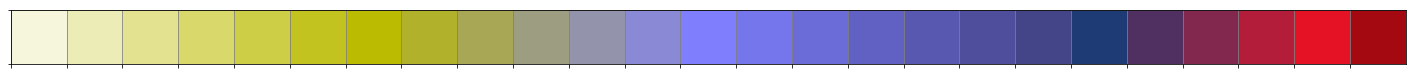

gist_yarg


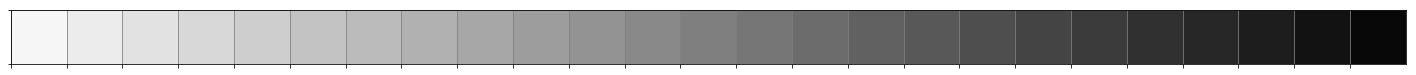

gist_yarg_r


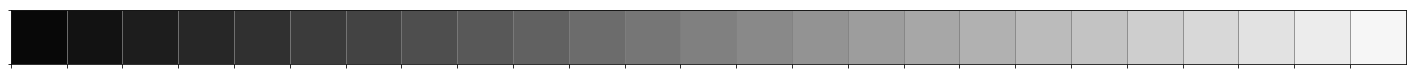

gnuplot


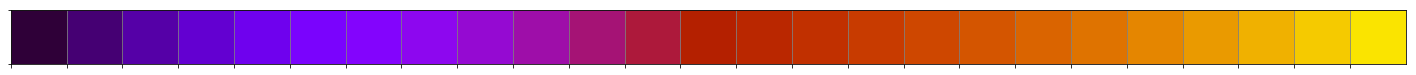

gnuplot2


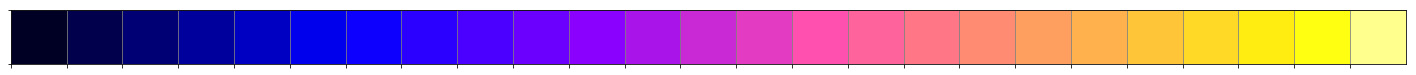

gnuplot2_r


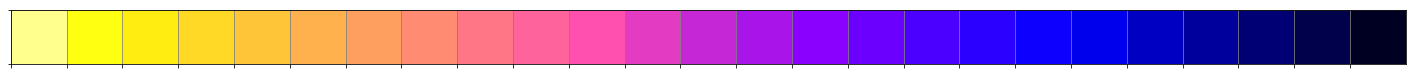

gnuplot_r


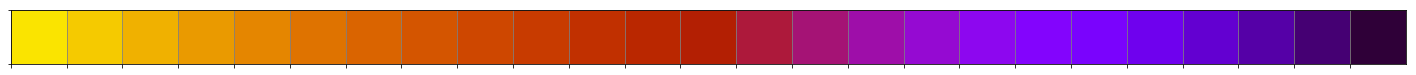

gray


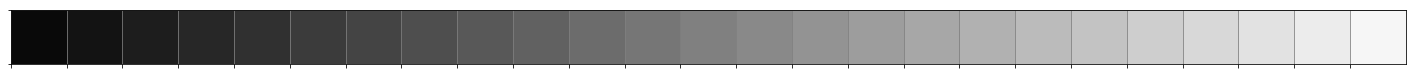

gray_r


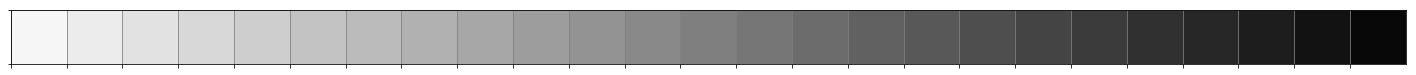

hot


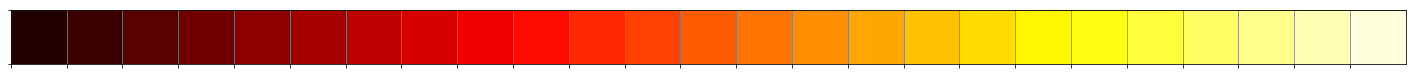

hot_r


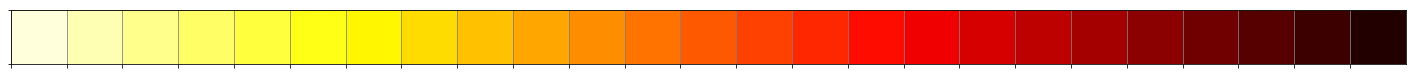

hsv


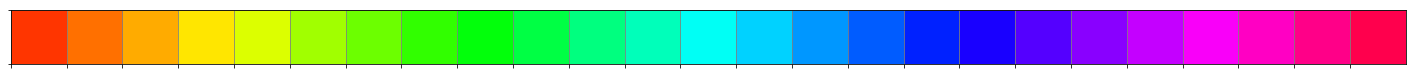

hsv_r


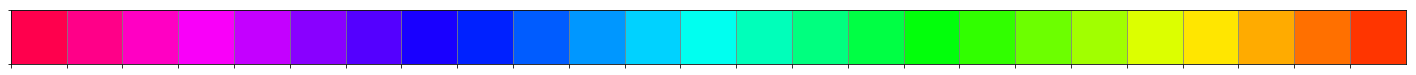

icefire


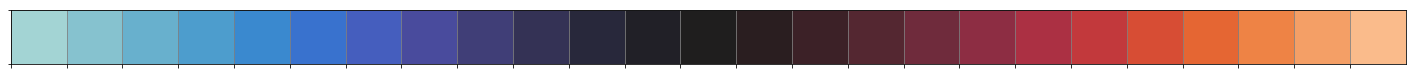

icefire_r


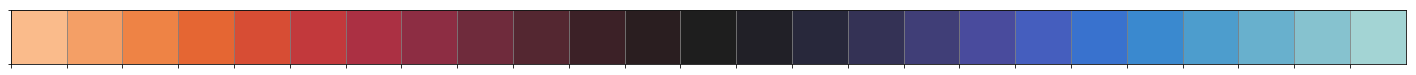

inferno


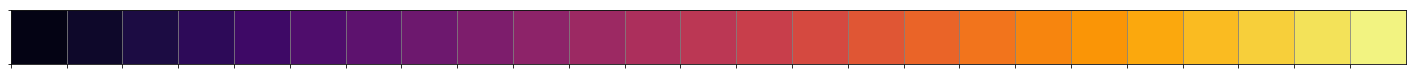

inferno_r


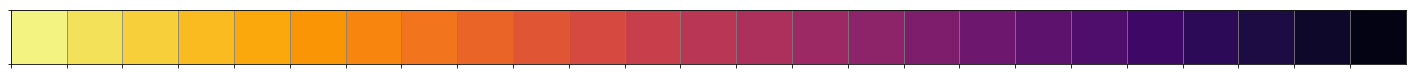

jet
jet_r


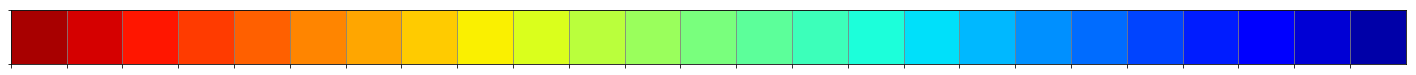

magma


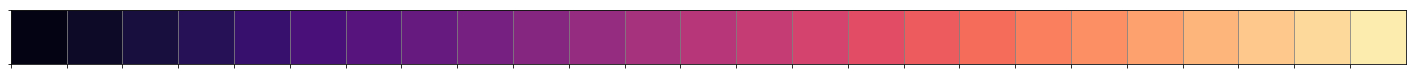

magma_r


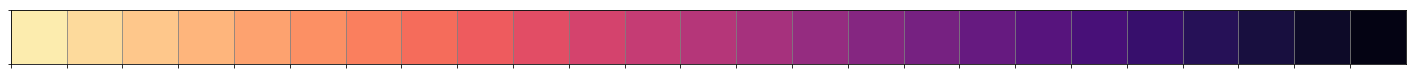

mako


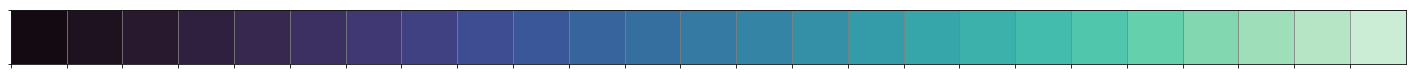

mako_r


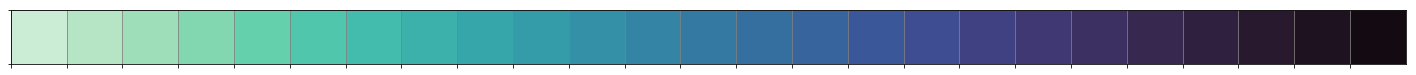

nipy_spectral


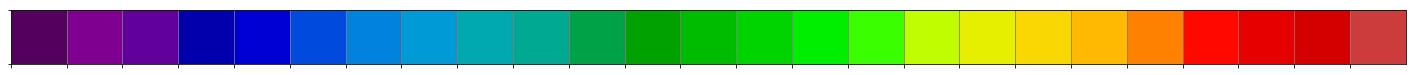

nipy_spectral_r


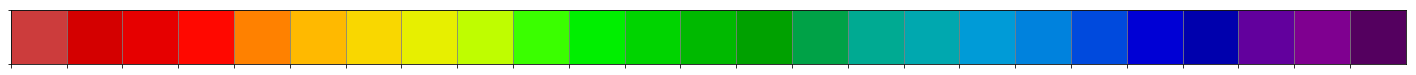

ocean


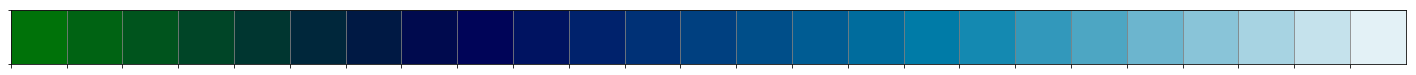

ocean_r


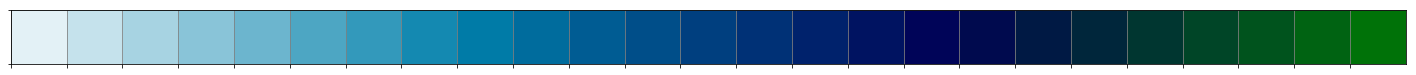

pink


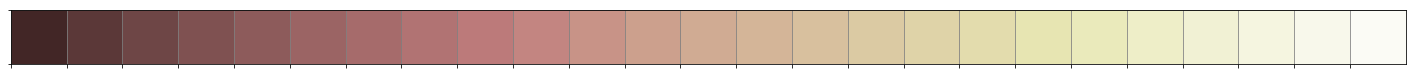

pink_r


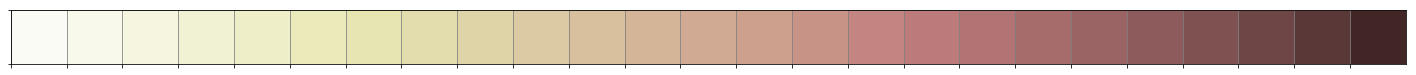

plasma


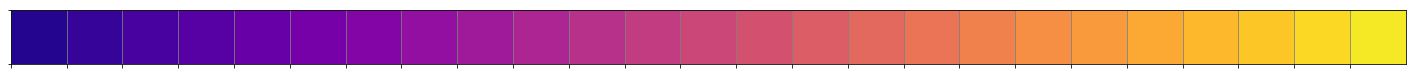

plasma_r


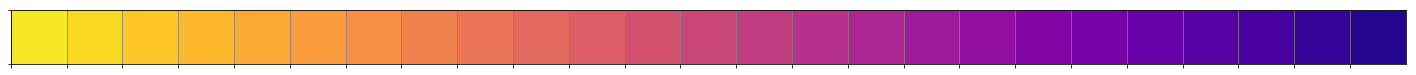

prism


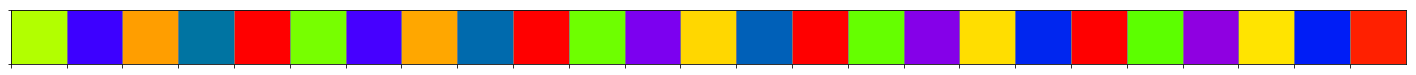

prism_r


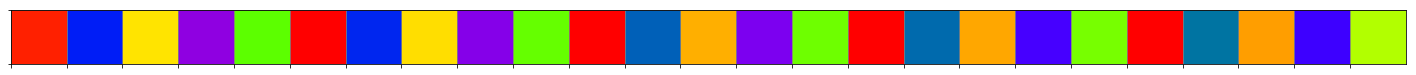

rainbow


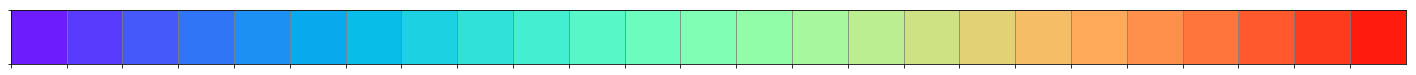

rainbow_r


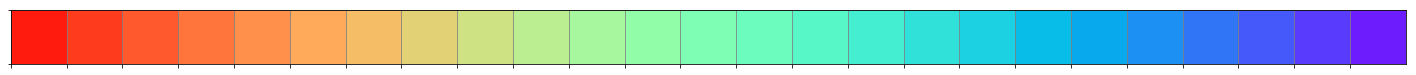

rocket


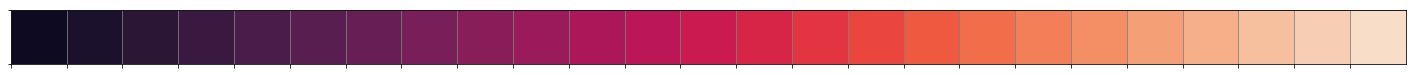

rocket_r


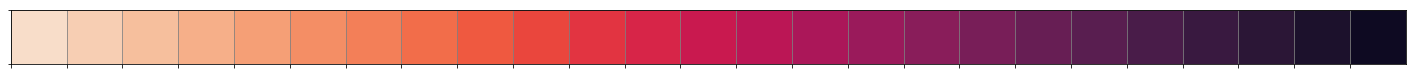

seismic


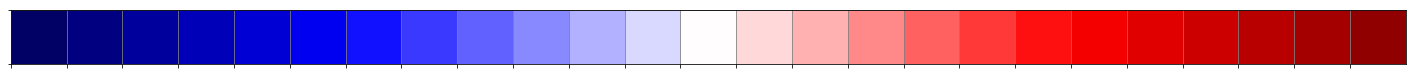

seismic_r


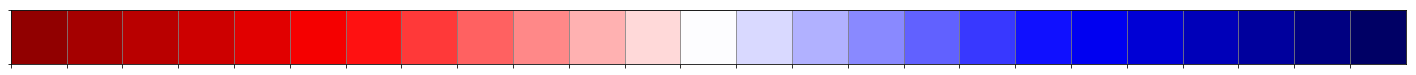

spring


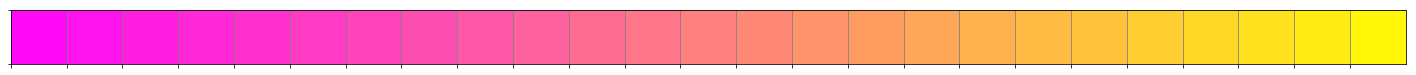

spring_r


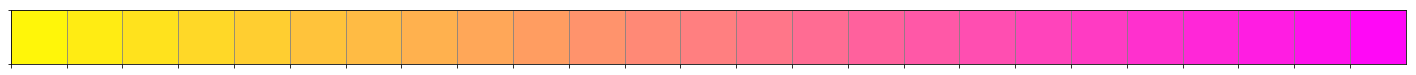

summer


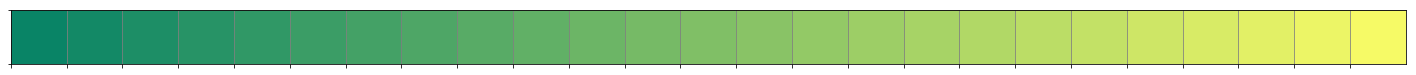

summer_r


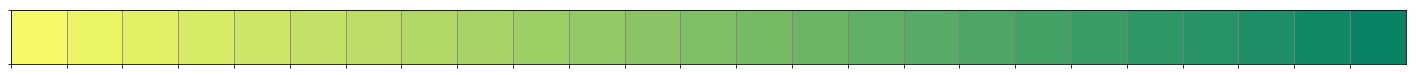

tab10


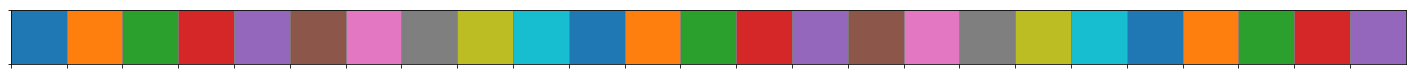

tab10_r


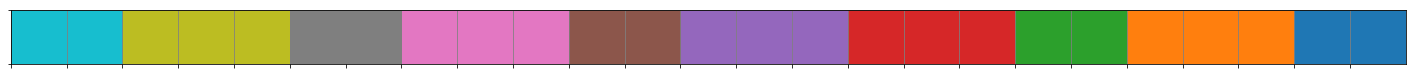

tab20


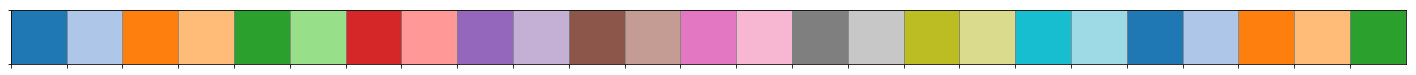

tab20_r


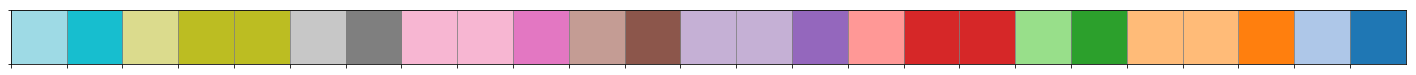

tab20b


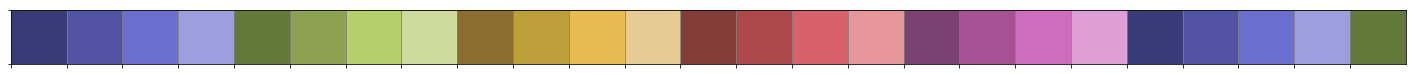

tab20b_r


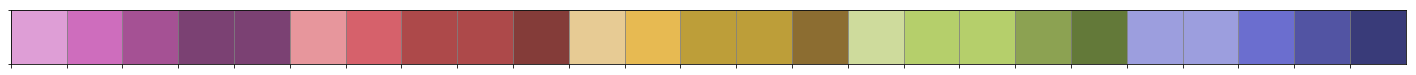

tab20c


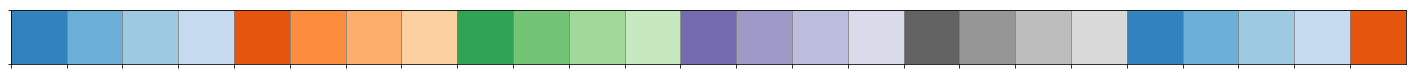

tab20c_r


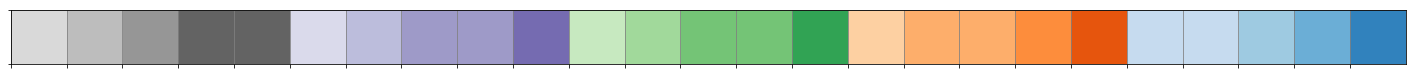

terrain


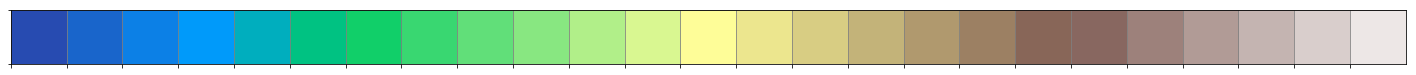

terrain_r


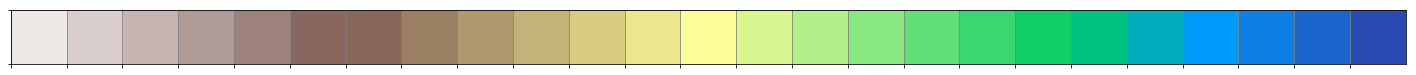

twilight


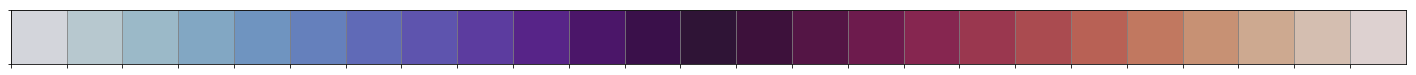

twilight_r


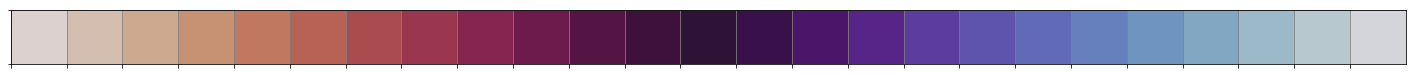

twilight_shifted


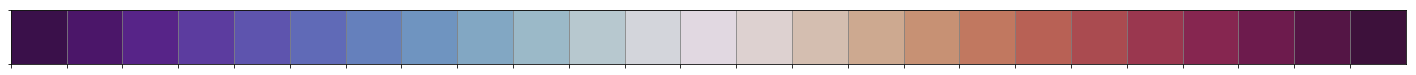

twilight_shifted_r


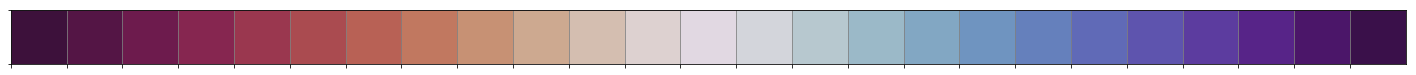

viridis


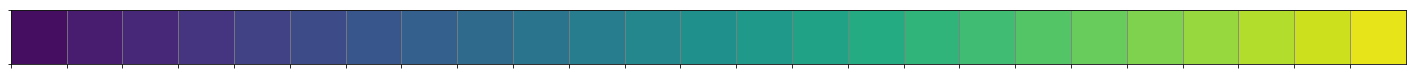

viridis_r


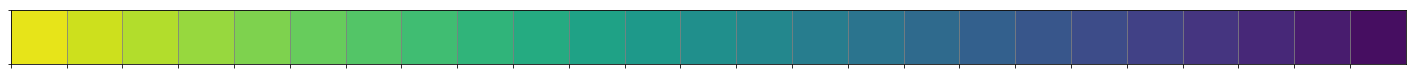

vlag


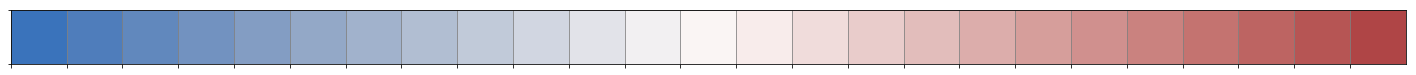

vlag_r


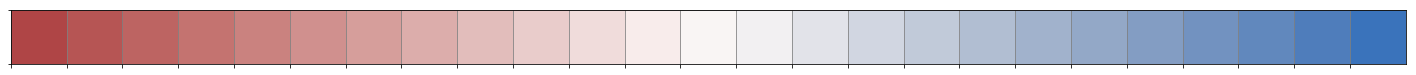

winter


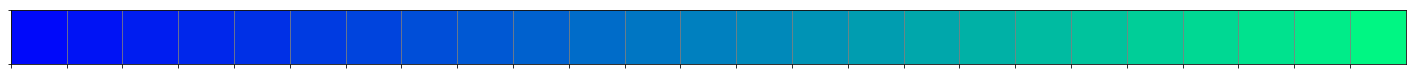

winter_r


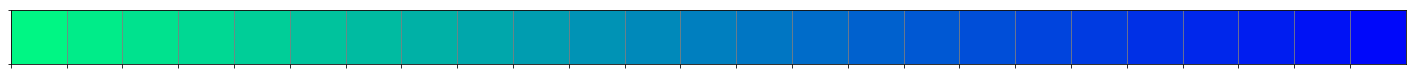

In [48]:
with open('C:\\Users\\alexandr.pankratov\\Desktop\\кешки петона\\SNS palettes.txt','r') as p:
    for hui in p:
        try:
            print(hui[:-1:])
            sns.palplot(sns.color_palette(hui[:-1:],25))
            plt.show()
        except:
            ko=3